In [12]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from Solver import nummodel, nummodel_jac, explicit_solve, implicit_solve
from NeuralNet import *
from timeit import default_timer



# Training a quadratic function

In [16]:
nn_save_name = "quadratic.nn"
N_train = 10000
x_train = np.linspace(-1,1, N_train).reshape((N_train, 1))
y_train = x_train ** 2
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 2000
batch_size = 16

layers = 2
width  = 10
model = FNN(ind, outd, layers, width) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)
        
        loss = myloss(out , y)
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

        scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(model, nn_save_name)
        
#     print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)




Epoch :  0  Epoch time :  0.37999567199995  Train L2 Loss :  169.93568828329444
Epoch :  100  Epoch time :  0.35954045400012546  Train L2 Loss :  52.00917636230588
Epoch :  200  Epoch time :  0.270918048999647  Train L2 Loss :  52.0091761611402
Epoch :  300  Epoch time :  0.29851439300000493  Train L2 Loss :  52.00917615741491
Epoch :  400  Epoch time :  0.26852352100013377  Train L2 Loss :  52.00917627476156
Epoch :  500  Epoch time :  0.26898205500037875  Train L2 Loss :  52.00917620584369
Epoch :  600  Epoch time :  0.27287281499957317  Train L2 Loss :  52.009176187217236
Epoch :  700  Epoch time :  0.29636461400014014  Train L2 Loss :  52.0091762393713
Epoch :  800  Epoch time :  0.27815800799999124  Train L2 Loss :  52.00917615927756
Epoch :  900  Epoch time :  0.2730865819999053  Train L2 Loss :  52.00917614251375
Epoch :  1000  Epoch time :  0.34406268400016415  Train L2 Loss :  52.009176183491945
Epoch :  1100  Epoch time :  0.3225998090001667  Train L2 Loss :  52.0091762505471

# Testing on the quadratic function

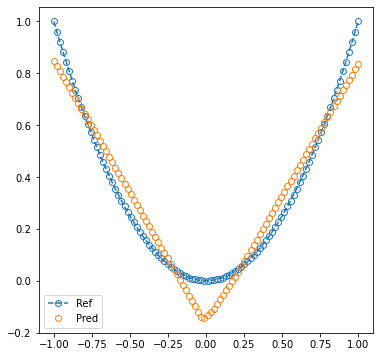

In [17]:
N_test = 100
x_test = np.linspace(-1,1, N_test).reshape((N_test, 1))
y_test = x_test ** 2
y_pred = model(torch.from_numpy(x_test.astype(np.float32))).detach().numpy()

fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(x_test,  y_test, "--o", fillstyle = "none", label="Ref")
ax.plot(x_test,  y_pred, "o",   fillstyle = "none", label="Pred")
ax.legend()